### Working on GSOC

## Task 1: Social Media Data Extraction & Preprocessing (API Handling & Text Cleaning)


In [ ]:
#Importing the required libraries

import pandas as pd
import tweepy
import time

In [ ]:
### My keys

API_KEY = "MQl6JqRK2YTb1AQg1leAiu6ET"
API_SECRET = "GSq3rZN0d86zkBDx6s8JkI5ZkAIaHJ5897hlwluy4ibbLNLlcM"
BEARER_TOKEN = "AAAAAAAAAAAAAAAAAAAAAGRZZgEAAAAASCZ1Mw9xjXI6cyc7RMI9Lvurv%2FY%3DOtmBNmZk8Qgw1NaQ2wXtGfkICUU1Ng7mhbPDscuiqGiqdPEU3z"


In [ ]:
### making a test request to verify authentication

import tweepy

bearer_token = BEARER_TOKEN

client = tweepy.Client(bearer_token=bearer_token)

try:
    client.get_user(username="TwitterDev")  # Test request
    print("API Authentication Successful")
except Exception as e:
    print(f" Authentication Failed: {e}")


In [ ]:
### Authenticate with Twitter API

client = tweepy.Client(bearer_token=BEARER_TOKEN)

In [ ]:
### some widely recognized terms in mental health discussions

keywords = [
    "depression",
    "anxiety disorder",
    "bipolar disorder",
    "post-traumatic stress disorder",
    "obsessive-compulsive disorder",
    "schizophrenia",
    "eating disorder",
    "substance use disorder",
    "self-harm",
    "suicidal ideation"
]


In [ ]:
### Constructing the Search Query

query = " OR ".join(keywords) + " -is:retweet lang:en"

In [ ]:
### Retry logic for handling rate limits or temporary failures

max_retries = 5  # Number of retry attempts
retry_delay = 15  # Initial delay in seconds

for attempt in range(max_retries):
    try:
        # Fetch tweets (max 100 per request)
        tweets = client.search_recent_tweets(
            query=query,
            tweet_fields=["id", "text", "created_at", "public_metrics"],
            max_results=100
        )
        break  # If successful, exit loop

    except tweepy.TooManyRequests:  # Handle rate limits
        print(f"Rate limit exceeded. Retrying in {retry_delay} seconds...")
        time.sleep(retry_delay)
        retry_delay *= 2  # Exponential backoff

    except tweepy.TweepyException as e:  # Catch general Tweepy errors
        print(f"Error: {e}")
        time.sleep(retry_delay)


In [ ]:
# Store extracted data
data = []
for tweet in tweets.data:
    data.append({
        "Post ID": tweet.id,
        "Timestamp": tweet.created_at,
        "Content": tweet.text,
        "Likes": tweet.public_metrics["like_count"],
        "Replies": tweet.public_metrics["reply_count"],
        "Retweets": tweet.public_metrics["retweet_count"]
    })


### was getting requests issues, hence shifted to reddit API

In [17]:
### Reddit Data Extraction

import praw
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
import emoji
import os

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from datetime import datetime

# Ensure stopwords are downloaded
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))



[nltk_data] Downloading package stopwords to /home/aakash/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
# Initialize Reddit API connection

user_agent= "user_agent"  #no space

reddit = praw.Reddit(
    client_id="-ggPSBpmj6tuwdfm-Av6vQ",
    client_secret="hP__xX396bg68yxyS9GzsCogUywMUQ",
    user_agent=user_agent
)


In [19]:
### some widely recognized terms in mental health discussions

keywords = [
    "depression",
    "anxiety disorder",
    "bipolar disorder",
    "post-traumatic stress disorder",
    "obsessive-compulsive disorder",
    "schizophrenia",
    "eating disorder",
    "substance use disorder",
    "self-harm",
    "suicidal ideation"
]


In [20]:
# List of subreddits to extract from
subreddit_name = [
    "mentalhealth", "depression", "addiction", "SuicideWatch",
    "traumatoolbox", "socialanxiety", "Anger", "offmychest", 
    "bodyacceptance", "mentalhealthmemes", 
    "nosurf", "mentalhealth"
]


In [21]:
import requests

def is_subreddit_accessible(subreddit_name):
    url = f"https://www.reddit.com/r/{subreddit_name}/about.json"
    headers = {"User-Agent": "your_user_agent"}
    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        return True  # ✅ Subreddit is accessible
    else:
        print(f"❌ Subreddit r/{subreddit_name} is private, banned, or doesn't exist.")
        return False  # ❌ Remove this subreddit from the list



In [22]:
# ✅ Filter only accessible subreddits


valid_subreddits = [sub for sub in subreddit_name if is_subreddit_accessible(sub)]
print(f"✅ Valid subreddits: {valid_subreddits}")

❌ Subreddit r/mentalhealthmemes is private, banned, or doesn't exist.
✅ Valid subreddits: ['mentalhealth', 'depression', 'addiction', 'SuicideWatch', 'traumatoolbox', 'socialanxiety', 'Anger', 'offmychest', 'bodyacceptance', 'nosurf', 'mentalhealth']


In [23]:
# 🔹 Load stopwords
stop_words = set(stopwords.words('english'))

# 🔹 Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# 🔹 Function to clean text
def clean_text(text):
    if pd.isna(text):  # Handle NaN values
        return ""
    
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # Remove special characters
    tokens = word_tokenize(text)  # Tokenize text
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Apply lemmatization
    
    return ' '.join(tokens)

In [29]:
def get_reddit_posts(valid_subreddits, limit=100):
    all_posts = []
    
    for subreddit_name in valid_subreddits:
        print(f"🔹 Fetching posts from r/{subreddit_name}...")
        subreddit = reddit.subreddit(subreddit_name)
        
        for post in subreddit.hot(limit=limit):  # Fetch top 'hot' posts
            if any(keyword in post.title.lower() or keyword in post.selftext.lower() for keyword in keywords):
                all_posts.append({
                    "subreddit": subreddit_name,  # ✅ Store the subreddit name
                    "post_id": post.id,
                    "timestamp": datetime.utcfromtimestamp(post.created_utc).strftime('%Y-%m-%d %H:%M:%S'),
                    "content": clean_text(post.title + ' ' + post.selftext),
                    "upvotes": post.score,
                    "comments": post.num_comments,
                    "shares": post.num_crossposts
                })
    
    return all_posts


In [30]:
# Fetch posts
posts_data = get_reddit_posts(valid_subreddits, limit=200)
print(f"✅ Collected {len(posts_data)} posts.")


🔹 Fetching posts from r/mentalhealth...


/tmp/ipykernel_33549/421323477.py:13: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(post.created_utc).strftime('%Y-%m-%d %H:%M:%S'),


🔹 Fetching posts from r/depression...
🔹 Fetching posts from r/addiction...
🔹 Fetching posts from r/SuicideWatch...
🔹 Fetching posts from r/traumatoolbox...
🔹 Fetching posts from r/socialanxiety...
🔹 Fetching posts from r/Anger...
🔹 Fetching posts from r/offmychest...
🔹 Fetching posts from r/bodyacceptance...
🔹 Fetching posts from r/nosurf...
🔹 Fetching posts from r/mentalhealth...
✅ Collected 211 posts.


In [31]:
# Convert the collected data to a DataFrame
df = pd.DataFrame(posts_data)

# Save the dataset to a CSV file
filename = "reddit_posts.csv"
df.to_csv(filename, index=False, encoding="utf-8")
print(f"Data {filename}")


Data reddit_posts.csv


In [32]:
df.head()

,subreddit,post_id,timestamp,content,upvotes,comments,shares
0,mentalhealth,1jmqcxh,2025-03-29 16:40:31,cope feeling like youre behind life lost lot y...,10,5,0
1,mentalhealth,1jmt04q,2025-03-29 18:37:15,alone always sit alone daily intrusive thought...,5,2,0
2,mentalhealth,1jmfpse,2025-03-29 05:50:57,girlfriend undergoing ect im ive known girlfri...,52,48,0
3,mentalhealth,1jmph45,2025-03-29 16:00:37,indication folk staging intervention soon im s...,4,1,0
4,mentalhealth,1jmrkrt,2025-03-29 17:34:05,venttraumadump afraid wont well enough go ball...,3,3,0


In [33]:
df.shape

(211, 7)

In [34]:
print(df.info())  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211 entries, 0 to 210
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  211 non-null    object
 1   post_id    211 non-null    object
 2   timestamp  211 non-null    object
 3   content    211 non-null    object
 4   upvotes    211 non-null    int64 
 5   comments   211 non-null    int64 
 6   shares     211 non-null    int64 
dtypes: int64(3), object(4)
memory usage: 11.7+ KB
None


In [35]:
print(df.isnull().sum())  # Check missing values

subreddit    0
post_id      0
timestamp    0
content      0
upvotes      0
comments     0
shares       0
dtype: int64


In [36]:
df['content_length'] = df['content'].apply(len)
print(df['content_length'].describe())  # Get min, max, mean length of posts


count      211.000000
mean      1328.161137
std       1744.023971
min         49.000000
25%        487.000000
50%        843.000000
75%       1539.500000
max      14095.000000
Name: content_length, dtype: float64


In [37]:
print(df.sort_values(by='upvotes', ascending=False).head(5))  # Top 5 upvoted
print(df.sort_values(by='comments', ascending=False).head(5))  # Top 5 commented


         subreddit  post_id            timestamp  \
32      depression   doqwow  2019-10-29 14:52:02   
162     offmychest  1jlreto  2025-03-28 09:50:15   
64      depression  1jlk9ub  2025-03-28 02:02:08   
148  socialanxiety  1jjt79f  2025-03-25 20:19:27   
35      depression  1jm9yrj  2025-03-29 00:24:32   

                                               content  upvotes  comments  \
32   mostbroken leastunderstood rule helper may inv...     2363       177   
162  spent saving porn hour regret throwaway accoun...     1919       307   
64   tonight im going kill name gian im peru unfort...      453       131   
148  relative came humiliated dont work dont move d...      158        26   
35   dad said depression choice choosing depression...      154        97   

     shares  content_length  
32        2            3183  
162       0            1143  
64        0             920  
148       0            1024  
35        0              96  
      subreddit  post_id            timestam

In [ ]:
###  Cleaning the Text


In [38]:
df['content']

0      cope feeling like youre behind life lost lot y...
1      alone always sit alone daily intrusive thought...
2      girlfriend undergoing ect im ive known girlfri...
3      indication folk staging intervention soon im s...
4      venttraumadump afraid wont well enough go ball...
                             ...                        
206    urge cut everyone life boyfriend friend family...
207    still child well im since ive bad depression a...
208    nothing working im tired bipolar ii trauma dro...
209    postdepression weird feeling used depressed ag...
210    insurance gsc hi everyone im currently insured...
Name: content, Length: 211, dtype: object

In [39]:
# 🔹 Apply cleaning to dataset
df['cleaned_content'] = df['content'].apply(clean_text)

# 🔹 Save cleaned dataset
df.to_csv("cleaned_reddit_posts.csv", index=False)
print("✅ Cleaned dataset saved as cleaned_reddit_posts.csv")


✅ Cleaned dataset saved as cleaned_reddit_posts.csv


In [40]:
# 🔹 Drop the old content column
df = df.drop(columns=['content'])

# 🔹 Save the cleaned dataset
df.to_csv("cleaned_reddit_posts.csv", index=False)
print("✅ Cleaned dataset saved with only cleaned content.")


✅ Cleaned dataset saved with only cleaned content.


In [41]:
df.head()

,subreddit,post_id,timestamp,upvotes,comments,shares,content_length,cleaned_content
0,mentalhealth,1jmqcxh,2025-03-29 16:40:31,10,5,0,178,cope feeling like youre behind life lost lot y...
1,mentalhealth,1jmt04q,2025-03-29 18:37:15,5,2,0,603,alone always sit alone daily intrusive thought...
2,mentalhealth,1jmfpse,2025-03-29 05:50:57,52,48,0,719,girlfriend undergoing ect im ive known girlfri...
3,mentalhealth,1jmph45,2025-03-29 16:00:37,4,1,0,1001,indication folk staging intervention soon im s...
4,mentalhealth,1jmrkrt,2025-03-29 17:34:05,3,3,0,1817,venttraumadump afraid wont well enough go ball...


In [42]:
df['word_count'] = df['cleaned_content'].apply(lambda x: len(x.split()))
print(df['word_count'].describe())


count     211.000000
mean      196.549763
std       245.857646
min         9.000000
25%        70.000000
50%       126.000000
75%       227.000000
max      1939.000000
Name: word_count, dtype: float64


# Task 2

In [43]:
### 🔹 Step 1: Sentiment Analysis 


In [44]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer


In [45]:
# 🔹 Load pre-trained BERT sentiment model (DistilBERT-SST-2)

MODEL_NAME = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)


In [46]:
# 🔹 Function to classify sentiment


def classify_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    sentiment = "Positive" if torch.argmax(probs) == 1 else "Negative"
    return sentiment


In [47]:
# 🔹 Load your cleaned Reddit dataset
df = pd.read_csv("cleaned_reddit_posts.csv")

# 🔹 Apply BERT-based sentiment analysis
df["Sentiment"] = df["cleaned_content"].apply(classify_sentiment)


In [48]:
df['Sentiment'].value_counts()

Sentiment
Negative    208
Positive      3
Name: count, dtype: int64

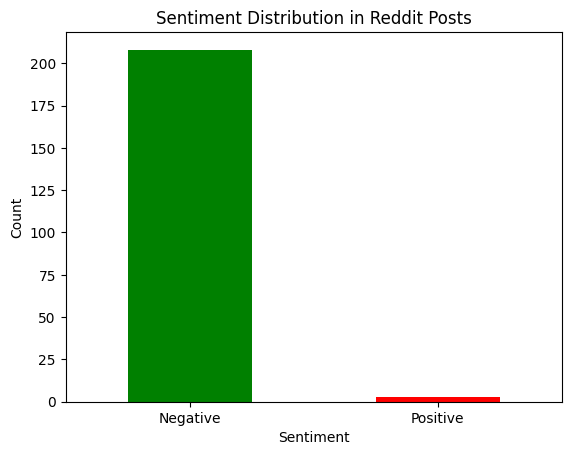

In [49]:
import matplotlib.pyplot as plt

# 🔹 Plot sentiment distribution
df["Sentiment"].value_counts().plot(kind="bar", color=["green", "red"])
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Sentiment Distribution in Reddit Posts")
plt.xticks(rotation=0)
plt.show()


In [50]:
from transformers import BertTokenizer, BertModel
import torch

# 🔹 Load BERT model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()



In [51]:
# 🔹 Apply BERT embedding extraction

df["bert_embedding"] = df["cleaned_content"].apply(get_bert_embedding)


In [52]:
df["bert_embedding"] 

0      [-0.065210484, 0.051498298, 0.5113644, -0.3147...
1      [0.036844797, 0.19994314, 0.597245, -0.1045754...
2      [-0.4317792, 0.08514319, 0.5397357, -0.1913758...
3      [-0.13409388, 0.14326204, 0.59459174, -0.09169...
4      [-0.3785818, 0.006924362, 0.7146765, 0.0193388...
                             ...                        
206    [-0.21317784, 0.24876373, 0.6285367, -0.122089...
207    [-0.16840787, 0.12846321, 0.6164041, -0.141022...
208    [-0.1699225, 0.36333868, 0.55185455, -0.168345...
209    [-0.34039456, 0.30973887, 0.46170864, -0.02372...
210    [-0.22407672, 0.18867493, 0.51025665, -0.06395...
Name: bert_embedding, Length: 211, dtype: object

In [53]:
import numpy as np

In [54]:
# Convert embeddings to array
X = np.vstack(df['bert_embedding'].values)


In [55]:
# Define risk keywords

high_risk_keywords = [
    "suicide", "end it", "kill myself", "no reason to live", "goodbye",
    "i can't go on", "want to disappear", "i want to die"
]
moderate_risk_keywords = [
    "feel lost", "struggling", "hopeless", "depressed", "numb",
    "no motivation", "lonely", "empty", "anxious", "tired of everything"
]



In [56]:
# Function to classify posts based on keywords
def classify_risk(text):
    text = text.lower()
    if any(term in text for term in high_risk_keywords):
        return 'High-Risk'
    elif any(term in text for term in moderate_risk_keywords):
        return 'Moderate Concern'
    else:
        return 'Low Concern'


In [57]:
# Apply the function
df['risk_level'] = df['cleaned_content'].apply(classify_risk)


In [58]:
# Check new class distribution
print(df['risk_level'].value_counts())


risk_level
Low Concern         116
Moderate Concern     80
High-Risk            15
Name: count, dtype: int64


In [59]:
# Convert labels to numerical format

y = df['risk_level'].map({'High-Risk': 2, 'Moderate Concern': 1, 'Low Concern': 0})

In [60]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


In [62]:
# Train Random Forest classifier with class weights
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)


In [64]:
# Print classification report
print(classification_report(y_test, y_pred, labels=[0, 1, 2], target_names=['Low Concern', 'Moderate Concern', 'High-Risk']))


                  precision    recall  f1-score   support

     Low Concern       0.68      0.96      0.79        24
Moderate Concern       0.78      0.41      0.54        17
       High-Risk       0.00      0.00      0.00         2

        accuracy                           0.70        43
       macro avg       0.48      0.46      0.44        43
    weighted avg       0.69      0.70      0.66        43



/home/aakash/miniconda3/envs/env1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aakash/miniconda3/envs/env1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aakash/miniconda3/envs/env1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

In [65]:
# 🔹 Load your cleaned Reddit dataset

df = pd.read_csv("cleaned_reddit_posts.csv")

In [67]:
df.head()

,subreddit,post_id,timestamp,upvotes,comments,shares,content_length,cleaned_content
0,mentalhealth,1jmqcxh,2025-03-29 16:40:31,10,5,0,178,cope feeling like youre behind life lost lot y...
1,mentalhealth,1jmt04q,2025-03-29 18:37:15,5,2,0,603,alone always sit alone daily intrusive thought...
2,mentalhealth,1jmfpse,2025-03-29 05:50:57,52,48,0,719,girlfriend undergoing ect im ive known girlfri...
3,mentalhealth,1jmph45,2025-03-29 16:00:37,4,1,0,1001,indication folk staging intervention soon im s...
4,mentalhealth,1jmrkrt,2025-03-29 17:34:05,3,3,0,1817,venttraumadump afraid wont well enough go ball...


In [ ]:
## Step 2: Crisis Risk Classification (TF-IDF & Rule-Based Detection)


In [69]:
high_risk_terms = [
    "i don’t want to be here", "i want to end it", "life is meaningless", 
    "no reason to live", "i can’t go on", "goodbye everyone", "ending it all"
]

moderate_risk_terms = [
    "i feel lost", "struggling", "overwhelmed", "i need help", "nobody understands", 
    "depressed", "can’t cope", "feeling empty"
]

# Function to classify crisis risk level
def classify_risk(text):
    text_lower = text.lower()
    if any(term in text_lower for term in high_risk_terms):
        return "High-Risk"
    elif any(term in text_lower for term in moderate_risk_terms):
        return "Moderate Concern"
    else:
        return "Low Concern"

# Apply risk classification
df["Risk_Level"] = df["cleaned_content"].apply(classify_risk)

# Save the updated dataset
df.to_csv("classified_twitter_data.csv", index=False)
print("✅ Crisis risk classification done!")


✅ Crisis risk classification done!


In [70]:
df.head()

,subreddit,post_id,timestamp,upvotes,comments,shares,content_length,cleaned_content,Risk_Level
0,mentalhealth,1jmqcxh,2025-03-29 16:40:31,10,5,0,178,cope feeling like youre behind life lost lot y...,Low Concern
1,mentalhealth,1jmt04q,2025-03-29 18:37:15,5,2,0,603,alone always sit alone daily intrusive thought...,Low Concern
2,mentalhealth,1jmfpse,2025-03-29 05:50:57,52,48,0,719,girlfriend undergoing ect im ive known girlfri...,Moderate Concern
3,mentalhealth,1jmph45,2025-03-29 16:00:37,4,1,0,1001,indication folk staging intervention soon im s...,Moderate Concern
4,mentalhealth,1jmrkrt,2025-03-29 17:34:05,3,3,0,1817,venttraumadump afraid wont well enough go ball...,Low Concern


In [71]:
### 🔹 Step 3: Visualizing Sentiment & Risk Distribution


In [73]:
df.head()

,subreddit,post_id,timestamp,upvotes,comments,shares,content_length,cleaned_content,Risk_Level
0,mentalhealth,1jmqcxh,2025-03-29 16:40:31,10,5,0,178,cope feeling like youre behind life lost lot y...,Low Concern
1,mentalhealth,1jmt04q,2025-03-29 18:37:15,5,2,0,603,alone always sit alone daily intrusive thought...,Low Concern
2,mentalhealth,1jmfpse,2025-03-29 05:50:57,52,48,0,719,girlfriend undergoing ect im ive known girlfri...,Moderate Concern
3,mentalhealth,1jmph45,2025-03-29 16:00:37,4,1,0,1001,indication folk staging intervention soon im s...,Moderate Concern
4,mentalhealth,1jmrkrt,2025-03-29 17:34:05,3,3,0,1817,venttraumadump afraid wont well enough go ball...,Low Concern


/tmp/ipykernel_33549/4124987799.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["Risk_Level"], palette="coolwarm")


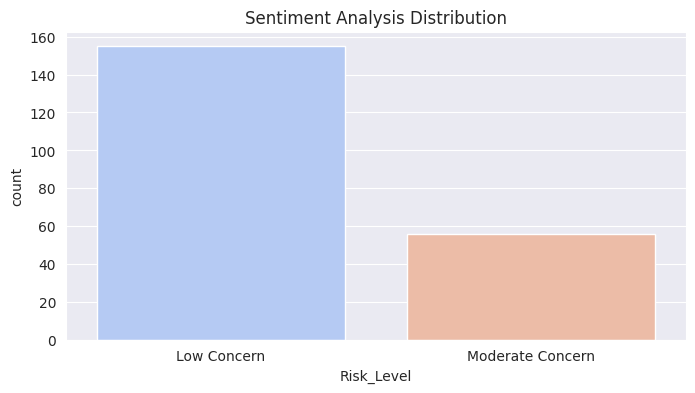

/tmp/ipykernel_33549/4124987799.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["Risk_Level"], palette="Reds")


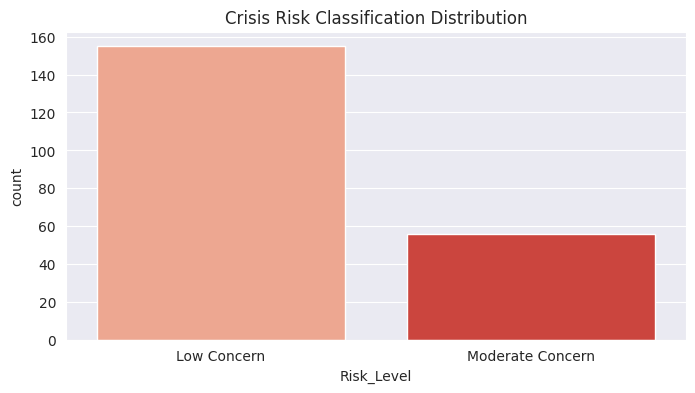

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("darkgrid")

# Plot sentiment distribution
plt.figure(figsize=(8, 4))
sns.countplot(x=df["Risk_Level"], palette="coolwarm")
plt.title("Sentiment Analysis Distribution")
plt.show()

# Plot risk level distribution
plt.figure(figsize=(8, 4))
sns.countplot(x=df["Risk_Level"], palette="Reds")
plt.title("Crisis Risk Classification Distribution")
plt.show()


# Task 3

In [75]:
df.columns

Index(['subreddit', 'post_id', 'timestamp', 'upvotes', 'comments', 'shares',
       'content_length', 'cleaned_content', 'Risk_Level'],
      dtype='object')

In [76]:
df.shape

(211, 9)

In [77]:
import folium
from folium.plugins import HeatMap
from geopy.geocoders import Nominatim
import spacy

# Load a more robust NLP model
nlp = spacy.load("en_core_web_trf")


In [78]:
# Function to extract locations from text
def extract_location(text):
    doc = nlp(text)
    locations = [ent.text for ent in doc.ents if ent.label_ == "GPE"]
    return locations[0] if locations else None



In [79]:
# Apply location extraction
df['location'] = df['cleaned_content'].apply(extract_location)


In [80]:
df['location'].value_counts()

location
michigan          2
green shield      2
middle nowhere    1
pennsylvania      1
angola africa     1
colorado          1
southern state    1
panama city       1
ve                1
america           1
grey area         1
new area          1
country           1
virginia          1
canada            1
Name: count, dtype: int64

In [82]:
#Geocode valid locations
geolocator = Nominatim(user_agent="geo_crisis_analysis")

def geocode_location(location):
    if location:
        try:
            geo = geolocator.geocode(location)
            return (geo.latitude, geo.longitude) if geo else None
        except:
            return None
    return None

In [83]:

df['coordinates'] = df['location'].apply(geocode_location)
df = df.dropna(subset=['coordinates'])

In [84]:

# Generate Heatmap
def generate_heatmap(data):
    heatmap_data = [(lat, lon) for lat, lon in data]
    map_ = folium.Map(location=[20, 0], zoom_start=2)
    HeatMap(heatmap_data).add_to(map_)
    return map_



In [85]:
heatmap = generate_heatmap(df['coordinates'].tolist())
heatmap.save("crisis_heatmap.html")


True

Opening in existing browser session.


In [89]:
import folium
from folium.plugins import HeatMap

def generate_heatmap_with_markers(data):
    # Create base map
    map_ = folium.Map(location=[20, 0], zoom_start=2)
    
    # Extract heatmap coordinates
    heatmap_data = [(lat, lon) for lat, lon, name in data]
    HeatMap(heatmap_data).add_to(map_)

    # Add markers with labels
    for lat, lon, name in data:
        folium.Marker(
            location=[lat, lon],
            popup=name,  # Show name when clicked
            tooltip=name  # Show name on hover
        ).add_to(map_)

    return map_

# Convert your DataFrame's coordinates into a list of tuples (lat, lon, location_name)
location_data = [(lat, lon, name) for (lat, lon), name in zip(df['coordinates'], df['location'])]
heatmap = generate_heatmap_with_markers(location_data)

# Save and view
heatmap.save("crisis_heatmap_with_markers.html")


In [90]:
import webbrowser
webbrowser.open("crisis_heatmap_with_markers.html")


True

Opening in existing browser session.


In [ ]:
####### Task 3

In [ ]:
# Step 1: Extracting Location Data
##

In [ ]:
# Check available location data
print(df["Location"].value_counts().head(10))  # View top locations


In [ ]:
###📌 Extract Locations from Post Text


In [ ]:
import spacy

# Load English NLP model
nlp = spacy.load("en_core_web_sm")

# Function to extract locations
def extract_location(text):
    doc = nlp(text)
    for ent in doc.ents:
        if ent.label_ == "GPE":  # GPE = Geo-Political Entity (cities, countries, etc.)
            return ent.text
    return None  # No location found

# Apply location extraction
df["Extracted_Location"] = df["Cleaned_Content"].apply(extract_location)

# View extracted locations
print(df["Extracted_Location"].value_counts().head(10))


In [ ]:
## Step 2: Geocoding (Convert Locations to Lat/Lon)

In [ ]:
from geopy.geocoders import Nominatim
import time

geolocator = Nominatim(user_agent="geo_locator")

# Function to get latitude & longitude
def get_coordinates(location):
    if pd.isna(location):
        return None, None
    try:
        time.sleep(1)  # To avoid API rate limits
        loc = geolocator.geocode(location)
        if loc:
            return loc.latitude, loc.longitude
    except:
        return None, None
    return None, None

# Apply geocoding
df[["Latitude", "Longitude"]] = df["Extracted_Location"].apply(lambda x: pd.Series(get_coordinates(x)))

# Remove rows where coordinates are missing
df = df.dropna(subset=["Latitude", "Longitude"])

# Save the geocoded dataset
df.to_csv("geocoded_twitter_data.csv", index=False)
print("✅ Geolocation completed!")


In [ ]:
### 🔹 Step 3: Creating a Crisis Heatmap


In [ ]:
## generate heatmap

In [ ]:
import folium
from folium.plugins import HeatMap

# Initialize map centered at an approximate location
m = folium.Map(location=[20, 0], zoom_start=2)  # World view

# Add heatmap layer
heat_data = df[["Latitude", "Longitude"]].values.tolist()
HeatMap(heat_data).add_to(m)

# Save and display map
m.save("crisis_heatmap.html")
print("✅ Heatmap generated! Open 'crisis_heatmap.html' to view.")


In [ ]:
## 🔹 Step 4: Finding Top 5 Crisis Locations



In [ ]:
# Count top locations
top_locations = df["Extracted_Location"].value_counts().head(5)
print(top_locations)
